In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from narrative import nar181026_heat_confidence_genes
from narrative import nar181205_networks

In [6]:
save_images = True

In [7]:
outfolder = '211007_transcript_length_tilting_with_confidence_gene'

In [8]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')


tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

all_de = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['gene_ncbi'].isin(ref_genes))

]


In [10]:
from scipy.stats import spearmanr

In [11]:
from natsort import natsorted

In [12]:
conditions = natsorted(all_de['condition'].unique())

In [13]:
out = pd.DataFrame(index=conditions, columns=[
    'corr', 'pval'
]).rename_axis('condition')

In [14]:
pr = properties.genbank_gene(10090)[
    ['gene_ncbi', 'Genbank__gene: SumACGT']].rename(columns={
    'Genbank__gene: SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [15]:
%%time

for condition in conditions:
    d = all_de[
        (all_de['de_unit']=='both') & (all_de['condition']==condition)
    ]

    d = d[['gene_ncbi', 'o_over_y', 'log_padj', 'log_pvalue']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[condition, 'corr'] = r
    out.loc[condition, 'pval'] = p

CPU times: user 3min 50s, sys: 50.7 s, total: 4min 41s
Wall time: 2min 5s


In [16]:
# out = out.dropna()

In [17]:
out = out.reset_index()

In [18]:
out = pd.merge(out, all_de[['condition', 'younger', 'older']].drop_duplicates())

In [19]:
mega = pd.merge(
    out,
    all_de[['condition', 'tissue', 'younger', 'older']].drop_duplicates()
)

In [20]:
out.head()

,condition,corr,pval,younger,older
0,Adrenal_0_4_9,0.0244469,0.0068551,4.0,9.0
1,Adrenal_0_4_12,-0.0455945,1.90093e-07,4.0,12.0
2,Adrenal_0_4_18,0.0673443,4.33803e-15,4.0,18.0
3,Adrenal_0_4_24,-0.0771269,7.2125e-19,4.0,24.0
4,Adrenal_0_9_12,-0.0457368,1.43414e-08,9.0,12.0


In [21]:
u = out[out['younger']==4]

In [22]:
u['corr'] = u['corr'].astype(float)

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
u['older'] = u['older'].astype(float)

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
u = pd.merge(
    u,
    all_de[['condition', 'tissue']].drop_duplicates())

In [25]:
u[u['older']==24].sort_values('corr')

,condition,corr,pval,younger,older,tissue
11,Blood_0_4_24,-0.457332,3.61752e-54,4.0,24.0,Blood
35,Kidney_0_4_24,-0.423080,0,4.0,24.0,Kidney
55,SI_0_4_24,-0.380107,2.9657e-278,4.0,24.0,SI
39,LI_0_4_24,-0.331963,0,4.0,24.0,LI
63,Stomach_0_4_24,-0.292562,2.63174e-153,4.0,24.0,Stomach
27,GutEP_0_4_24,-0.197009,2.28356e-97,4.0,24.0,GutEP
7,BAT_0_4_24,-0.179237,4.73391e-82,4.0,24.0,BAT
23,Esophagus_0_4_24,-0.179144,1.17427e-66,4.0,24.0,Esophagus
31,Heart_0_4_24,-0.119482,1.26841e-49,4.0,24.0,Heart
51,MuscSat_0_4_24,-0.103976,9.17453e-32,4.0,24.0,MuscSat


In [26]:
from scipy.stats import mannwhitneyu

In [27]:
mannwhitneyu(
    u[u['older']==18]['corr'],
    u[u['older']==24]['corr'],
)

MannwhitneyuResult(statistic=74.0, pvalue=0.007953394008325442)

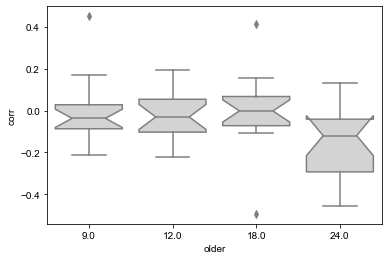

In [28]:
sns.boxplot(x='older', y='corr', data=u, notch=True, color='lightgrey')

if save_images:
    export.export_image('{}/box_4months_to_older.pdf'.format(outfolder))

In [29]:
pr = properties.genbank_validated_rna(10090)[
    ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})
pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

In [30]:
p = inout.get_internal_path(
    'datasets/tstoeger/200129_pool_inner_bootstraps/age_groups.csv.gz')

In [31]:
df_b = pd.read_csv(p)
tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

In [32]:
df_b = df_b[df_b['tissue'].isin(tissues_to_consider)].copy()



In [33]:
df_b = df_b.dropna(subset=['gene_ncbi'])

In [34]:
master_b = pd.merge(df_b, pr)

In [35]:
grouped = master_b.groupby(['tissue', 'age', 'animals'])

In [36]:
agg = []
for name, group in grouped:
    tissue, age, animals = name
    rho, pval = spearmanr(group['length'], group['o_over_y'])
    
    res = dict()
    res['tissue'] = tissue
    res['age'] = age
    res['rho'] = rho
    res['pval'] = pval
    res['animals'] = animals
    
    agg.append(res)

In [37]:
mega = pd.DataFrame(agg)

In [38]:
m = mega.groupby(['tissue', 'age']).agg(np.median).reset_index()

In [39]:
uu =u[['tissue', 'older', 'corr']]
uu.loc[:, 'origin'] = 'data'

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [40]:
mm = m[['tissue', 'age', 'rho']].rename(columns={
        'age': 'older',
        'rho': 'corr'
    })

In [41]:
mm.loc[:, 'origin'] = 'combos'

In [42]:
t = pd.concat(
[
    uu, 
    mm
    
])

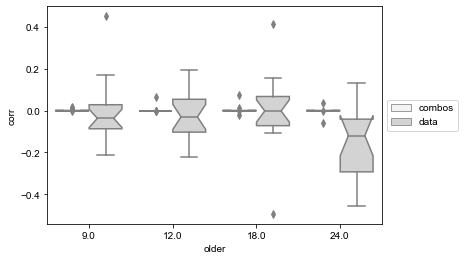

In [43]:
sns.boxplot(
    x='older', 
    y='corr', 
    data=t[t['older']>=9], 
    notch=True, 
    hue='origin',
    hue_order=['combos', 'data'],
    color='lightgrey')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



if save_images:
    export.export_image('{}/relative_to_control.pdf'.format(outfolder))

In [44]:
for j in [9, 12, 18, 24]:
    print(
        
        j,
        mannwhitneyu(
            t[(t['origin']=='combos') & (t['older']==j)]['corr'],
            t[(t['origin']=='data') & (t['older']==j)]['corr'],
            alternative='two-sided'
        ))

9 MannwhitneyuResult(statistic=170.0, pvalue=0.38918941278422226)
12 MannwhitneyuResult(statistic=157.0, pvalue=0.6793704322713003)
18 MannwhitneyuResult(statistic=147.0, pvalue=0.7052597160408953)
24 MannwhitneyuResult(statistic=235.0, pvalue=0.001935743045086168)


In [45]:
ms = mega[['tissue', 'age', 'rho']].rename(columns={
        'age': 'older',
        'rho': 'corr'
    })

In [46]:
ms.loc[:, 'origin'] = 'variations'

In [47]:
uu.head()

,tissue,older,corr,origin
0,Adrenal,9.0,0.024447,data
1,Adrenal,12.0,-0.045594,data
2,Adrenal,18.0,0.067344,data
3,Adrenal,24.0,-0.077127,data
4,BAT,9.0,0.050852,data


In [48]:
uu['short_label'] = uu['origin'] + '_' + uu['older'].astype(int).astype(str)

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
ms['short_label'] = ms['origin'] + '_' + ms['older'].astype(int).astype(str)

In [50]:
mm['short_label'] = mm['origin'] + '_' + mm['older'].astype(int).astype(str)

In [51]:
tt = pd.concat([
    uu,
    ms[ms['older']==4],
    mm[mm['older']==4]
    
    
])

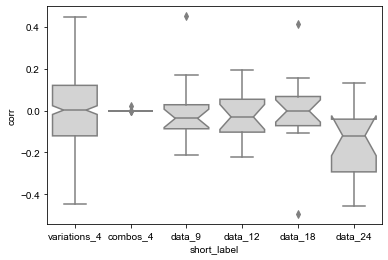

In [52]:
sns.boxplot(
    x='short_label', 
    y='corr', 
    data=tt, 
    notch=True, 
    order=['variations_4','combos_4', 'data_9', 'data_12', 'data_18', 'data_24'],
    color='lightgrey')

if save_images:
    export.export_image('{}/all_ages_and_controls.pdf'.format(outfolder))


In [53]:
tt['short_label'].unique()

array(['data_9', 'data_12', 'data_18', 'data_24', 'variations_4',
       'combos_4'], dtype=object)

In [54]:
for j in [9, 12, 18, 24]:
    print(
        
        j,
        mannwhitneyu(
            tt[(tt['short_label']=='combos_4')]['corr'],
            tt[(tt['origin']=='data') & (tt['older']==j)]['corr'],
            alternative='two-sided'
        ))

9 MannwhitneyuResult(statistic=170.0, pvalue=0.38918941278422226)
12 MannwhitneyuResult(statistic=154.0, pvalue=0.7565672012945115)
18 MannwhitneyuResult(statistic=154.0, pvalue=0.7565672012945115)
24 MannwhitneyuResult(statistic=238.0, pvalue=0.001358866830603586)


In [55]:
for j in [9, 12, 18, 24]:
    print(
        
        j,
        mannwhitneyu(
            tt[(tt['short_label']=='variations_4')]['corr'],
            tt[(tt['origin']=='data') & (tt['older']==j)]['corr'],
            alternative='two-sided'
        ))

9 MannwhitneyuResult(statistic=3007.0, pvalue=0.6173792872948789)
12 MannwhitneyuResult(statistic=2983.0, pvalue=0.659889223987318)
18 MannwhitneyuResult(statistic=2767.0, pvalue=0.9259260327270765)
24 MannwhitneyuResult(statistic=3992.0, pvalue=0.003264950042344241)
